In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))

## don't show warning
import warnings
warnings.filterwarnings('ignore')

## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn import metrics

## for system
import glob
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))
import basicTools as bt
import Escal as es

### for reload modules
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
datadir = os.path.realpath("../../data")

## the prefix and suffix for search 
filePref = f"{datadir}/" #"/MD-clst"
fileSuff = ".xtc"

## the input trajs
trajs = [x.replace(filePref, "").replace(fileSuff, "") 
         for x in sorted(glob.glob(f"{filePref}*{fileSuff}")) 
         if '000' in x
        ]
#trajs = ["003", "005"]

In [3]:
## The data per frames
skip = 5

### smooth
step    = 200
width   = 400
seg2vec = bt.segment.medoid

### similar metrix
similar = bt.dist.cosin

### evalute method
evalute = metrics.calinski_harabasz_score # et.evalute.cluster

# Input Data

In [4]:
Xlist = []
Elist = []
flist = []
for i in trajs:
    ### the structure data
    fn = "{:s}{:s}-rama.xvg".format(filePref,i)
    X = bt.feature.dih2X(pd.DataFrame(np.loadtxt(fn, comments=["@","#"],
                             dtype = {'names': ('Phi', 'Psi', 'Residue'),
                                     'formats': ('f', 'f', 'S7')})))  
    Xlist.append(np.array(X.loc[1::skip, :].reset_index(drop=True)))

    ### read the energy
    fn = "{:s}{:s}-potential.xvg".format(filePref,i)
    eng = pd.DataFrame(np.loadtxt(fn, comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))
    Elist.append(np.array(eng.loc[1::skip, 'energy']))
    
    ### base frequence in MHz
    ## 1000,000 for M and P, and 2 for even extension
    flist.append(500000*skip/eng.loc[len(eng)-1, "time"])

    

### output the data shape
dshape = pd.DataFrame({"Feature":[x.shape for x in Xlist], 
                        "Energy":[e.shape for e in Elist],
                        "Freq (MHz)": flist})
dshape.index = trajs
print("The shape of the input data is:")
dshape

The shape of the input data is:


,Feature,Energy,Freq (MHz)
000_0,"(20000, 124)","(20000,)",2.5
000_1,"(20000, 124)","(20000,)",2.5
000_2,"(20000, 124)","(20000,)",2.5
000_3,"(20000, 124)","(20000,)",2.5
000_4,"(20000, 124)","(20000,)",2.5
000_5,"(20000, 124)","(20000,)",2.5


In [5]:
## Check the base unit of frequence
try:
    if dshape['Freq (MHz)'].nunique() == 1:
        ufreq = flist[0]
        print("The base units of trajectores is", ufreq)
    else:
        raise
except:   
    print("The units of trajectories are not same")

The base units of trajectores is 2.5


# Data Rescaling

In [6]:
## do FFT rescaling
efft = es.Efft(Xlist, Elist)

## set the mapping tool
xmap = mt.LinearRegress()

## get the score
qmc = xmap.score(efft)

## Multiple Correlation Coefficient

Text(9.9, 0.8997517669042873, '#5 (10.0 MHz)\nQMC = 0.92')

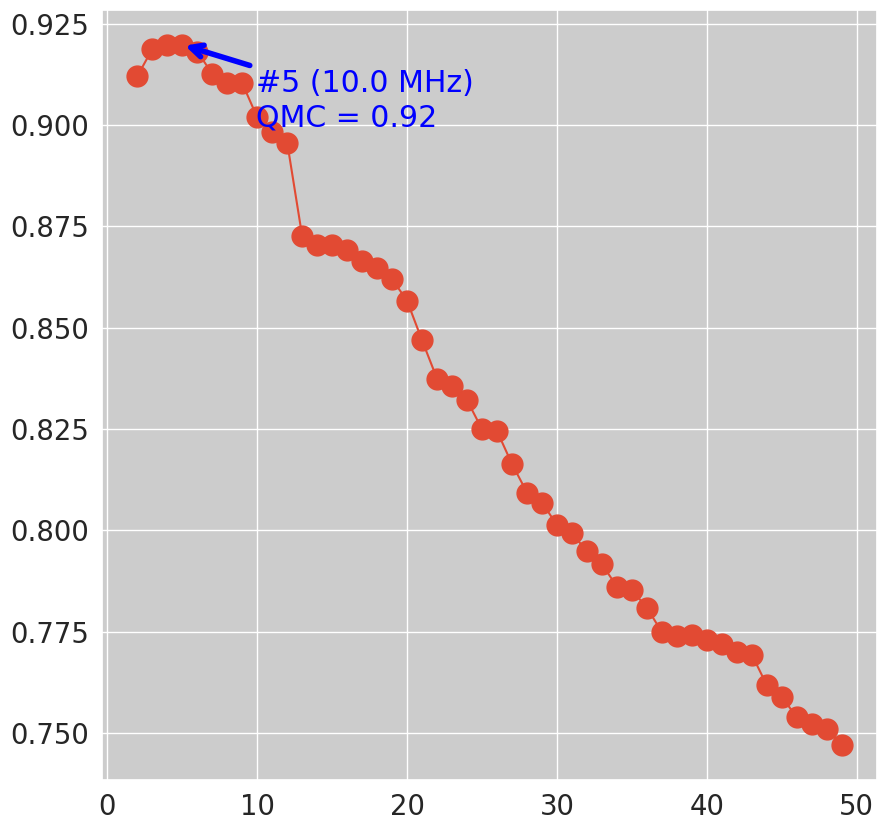

In [7]:
## plot the multiple correlation coefficient
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy    = (qmc['KappaMax'], qmc['qmcMax'])
xytxt = [xy[0]+0.1*np.max(qmc['list'][:,0]), xy[1]-0.02]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

## Weight of Features

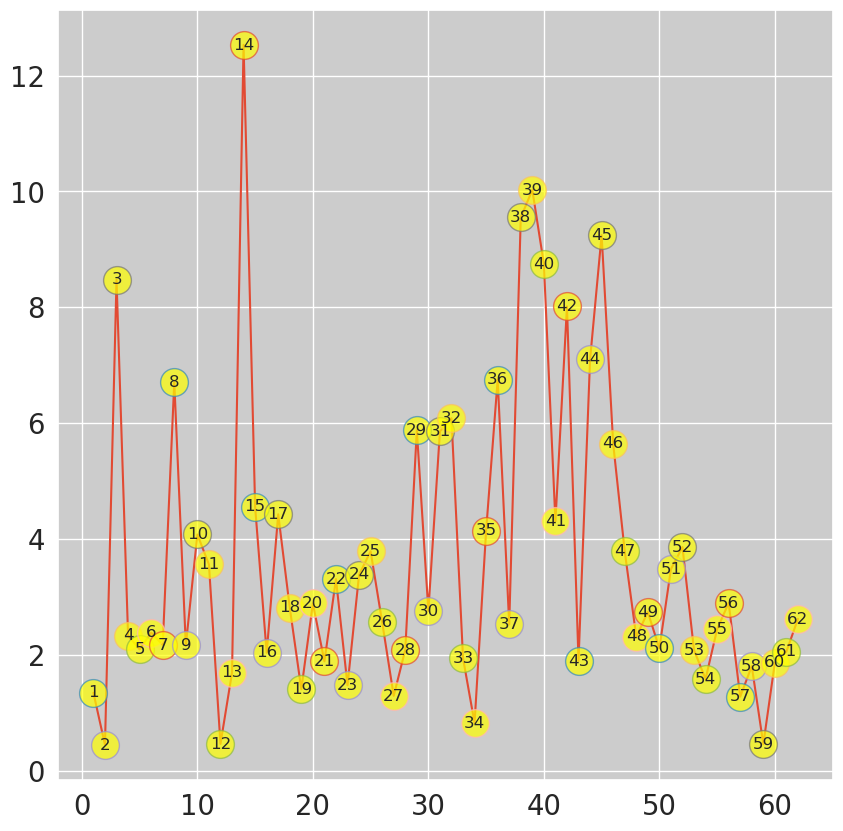

In [8]:
rescl = scl.rescale(qmc['KappaMax'])
fscal = []
for i in range(0, len(rescl['A']), 2):
    fscal.append(np.sqrt(rescl['A'][i]*rescl['A'][i] 
                + rescl['A'][i+1]*rescl['A'][i+1]))
bt.plot.coefplot(fscal)

## Distribution of Energy

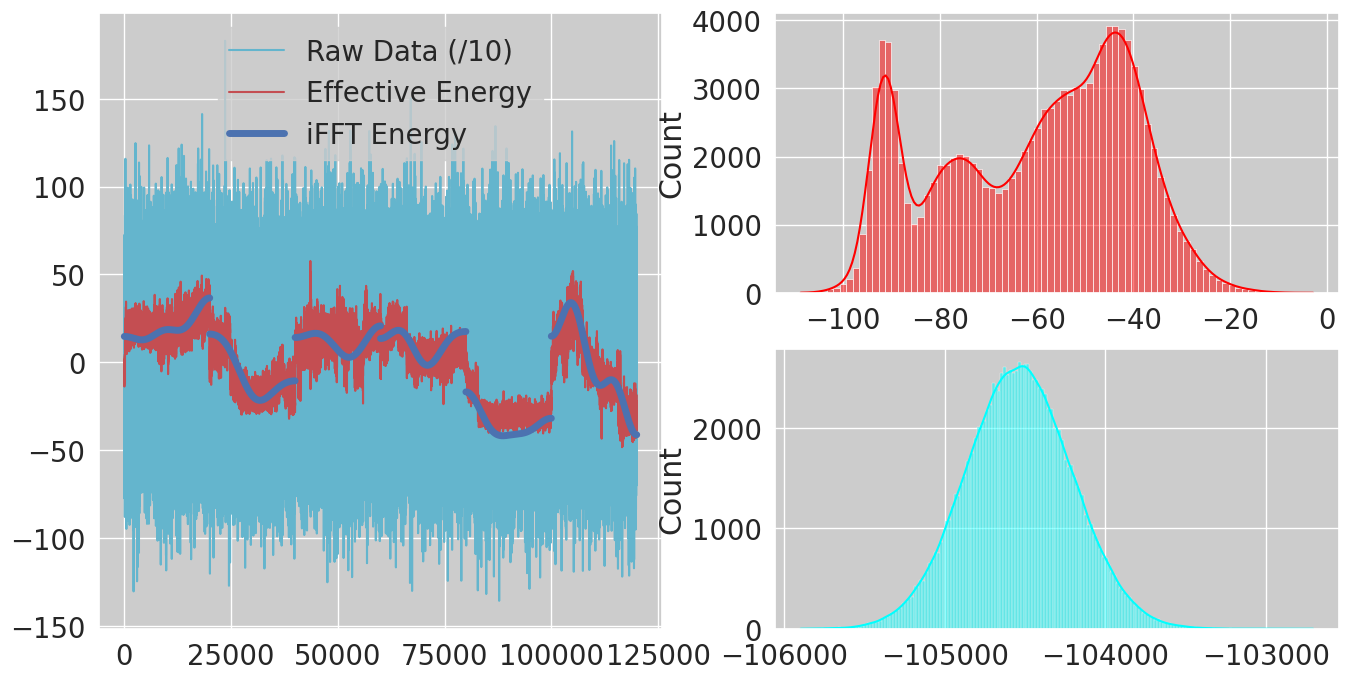

In [9]:
## plot Effective Energy
bt.plot.efplot(np.concatenate(Elist), rescl['Ef'], 
               np.concatenate([np.dot(x, rescl['A']) for x in Xlist]))

# Matrix Analysis

## Sample Data

In [10]:
## get the samples
Slist = []
for x in rescl['X']:
    Slist.append(seg2vec(x, step, width))
Xys = np.concatenate(Slist)

## Testing Similarity Matrix

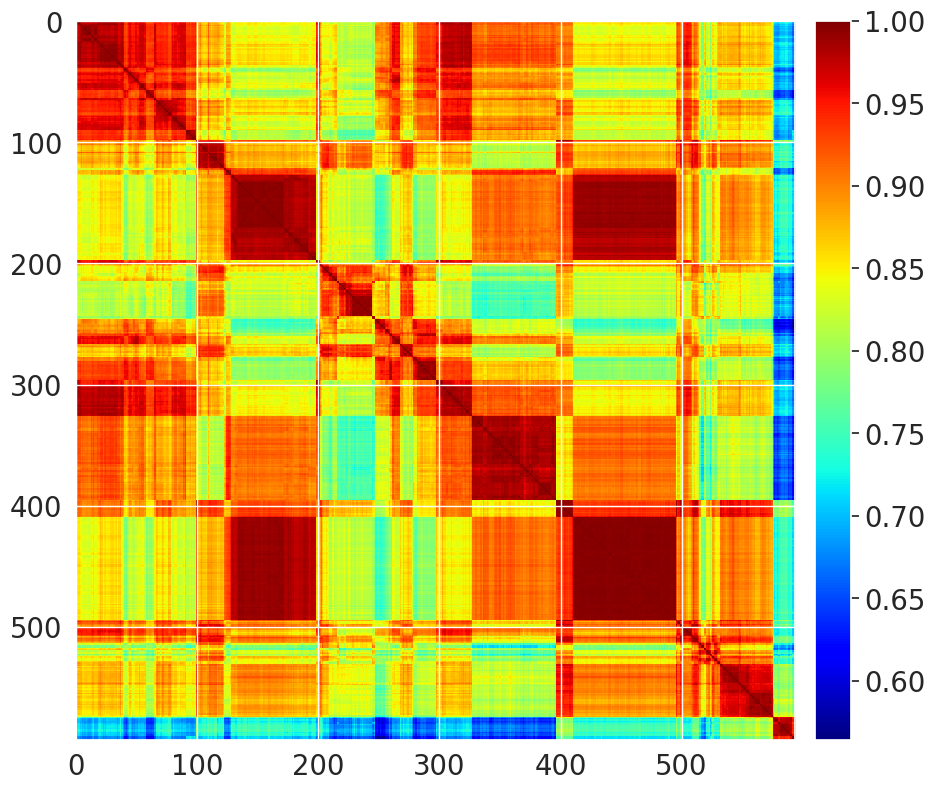

In [11]:
## set distance function and get distance
Smaty  = similar(Xys)
bt.plot.implot(Smaty)

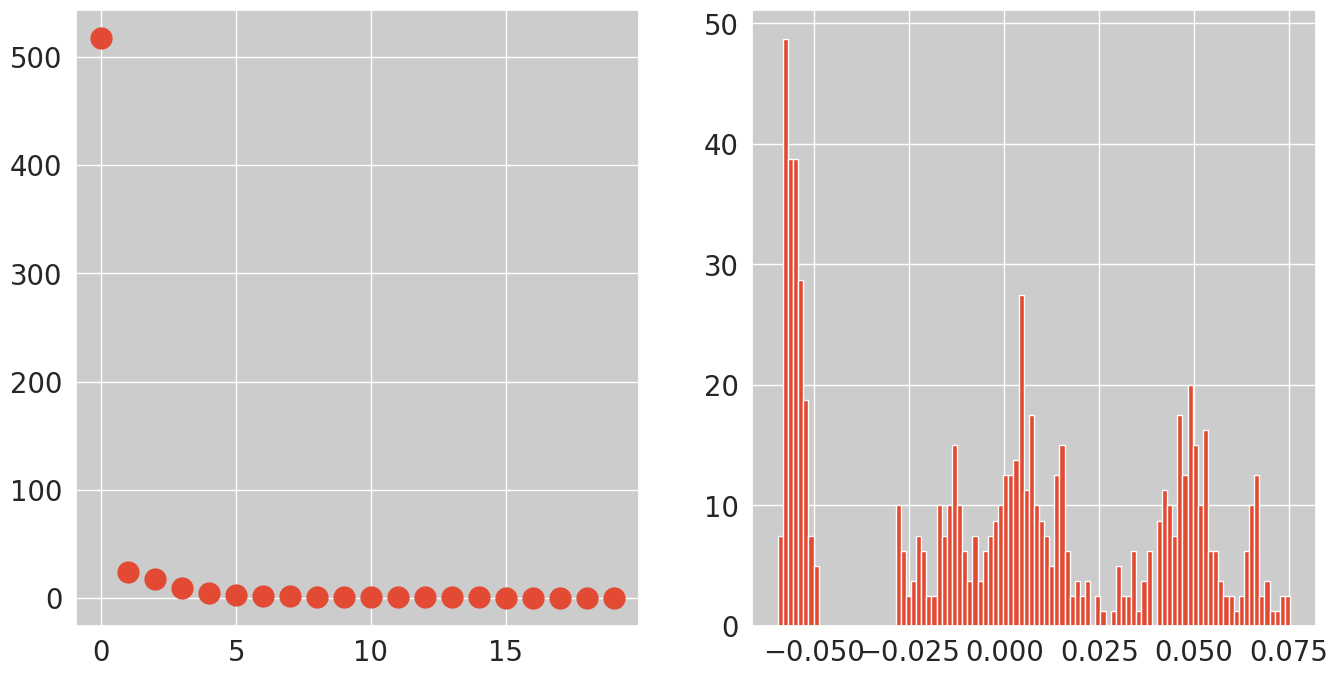

In [12]:
w,v = np.linalg.eig(Smaty)

fig, axs = plt.subplots(1,2, figsize=(16,8)) 
axs[0].plot(w[0:20], "o")
hist = axs[1].hist(v[:,1], bins=100, density=True)

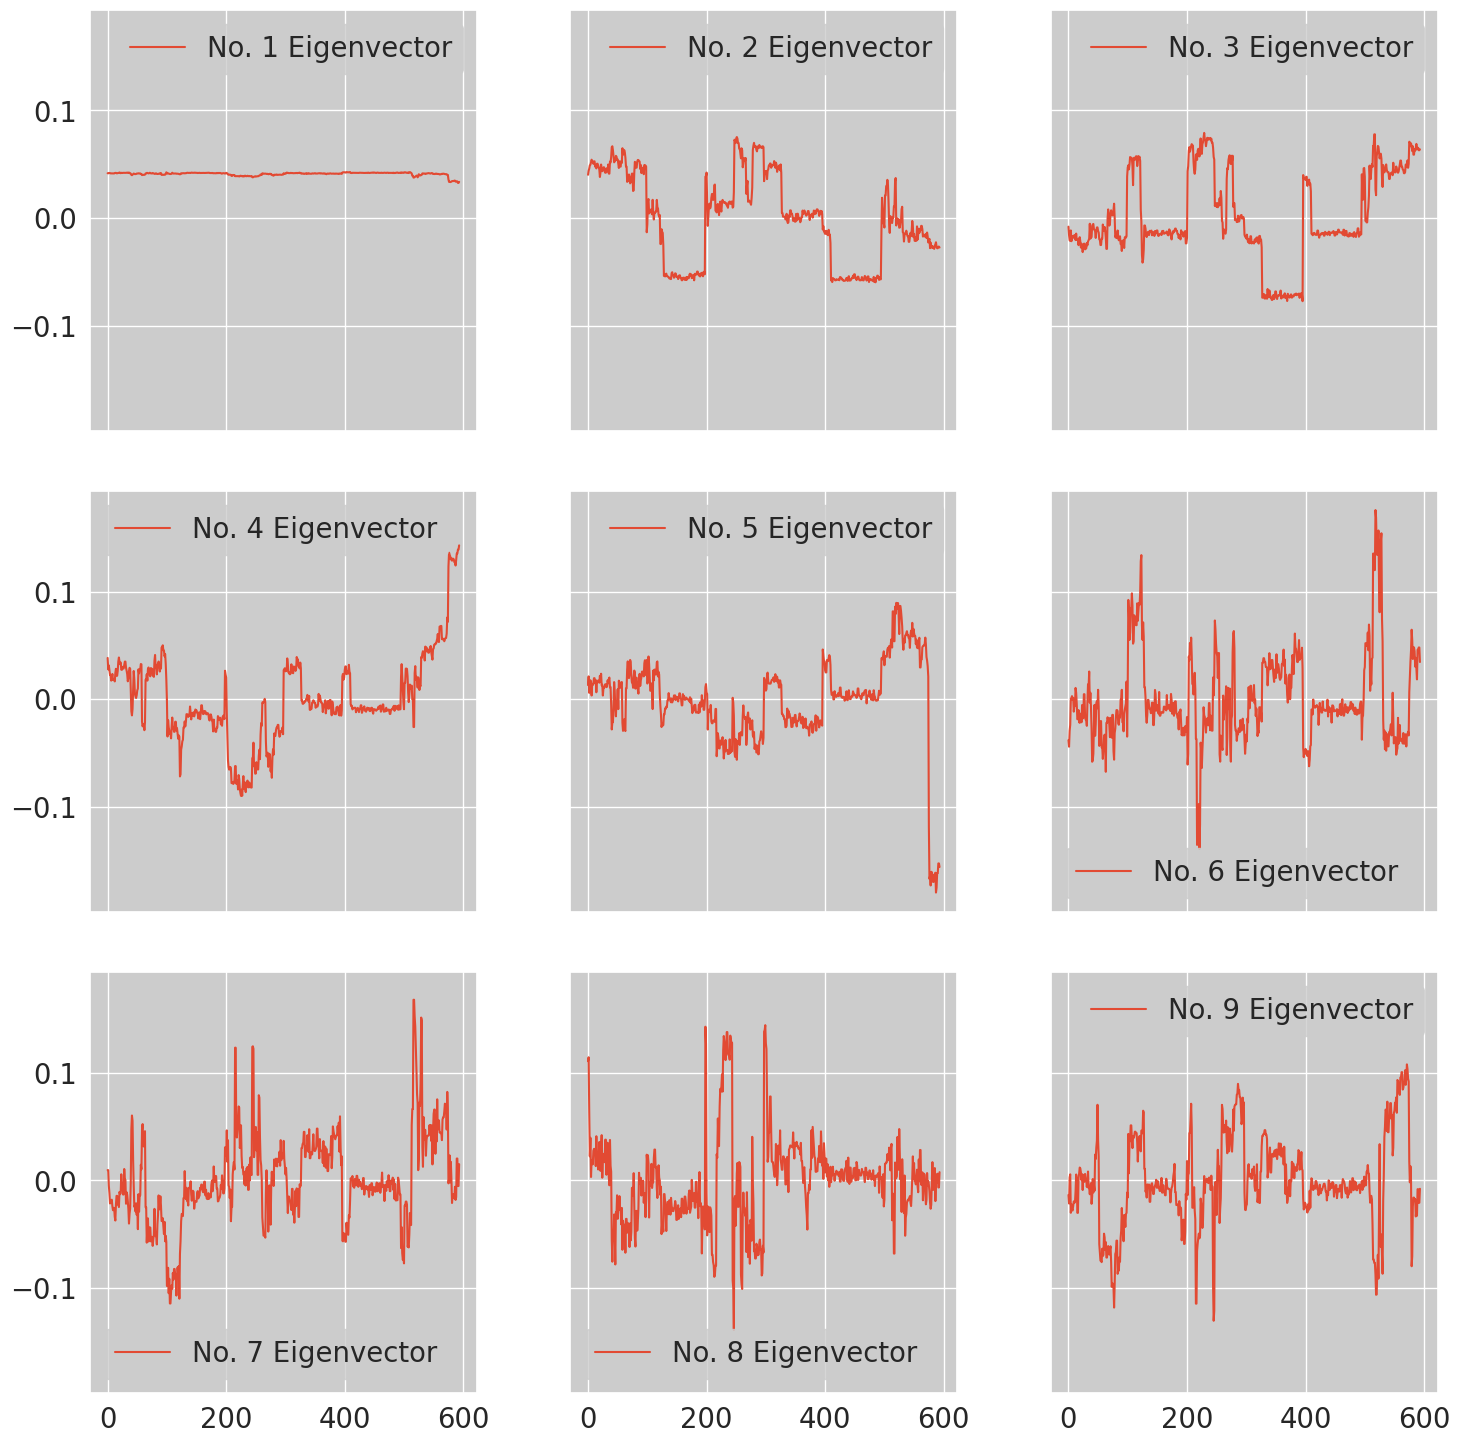

In [13]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

# Save Data

In [ ]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [ ]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = 'multiTraj.ipynb'
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"

!jupyter nbconvert --to pdf --no-input --log-level 40 --output-dir {datadir} {srcfile}